In [19]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt 

from sklearn.decomposition import PCA

# Envoltória Convexa
Computação da Envolória Convexa utilizando a Varredura de Graham

In [20]:
def orientation(p, q, r):
    val = (q[1] - p[1]) * (r[0] - q[0]) - (q[0] - p[0]) * (r[1] - q[1])
    if val == 0: return 0  # colinear
    return 1 if val > 0 else 2  # horário (1) ou anti-horário (2)

def polar_angle(p0, p1):
    y_span = p1[1] - p0[1]
    x_span = p1[0] - p0[0]
    return np.arctan2(y_span, x_span)

def distance(p0, p1):
    return (p1[0] - p0[0])**2 + (p1[1] - p0[1])**2

def graham_scan(points):
    n = len(points)

    # ponto com a coordenada y mais baixa
    ymin = min(points, key=lambda x: x[1])
    min_index = points.index(ymin)
    points[0], points[min_index] = points[min_index], points[0]  # troca o ponto inicial com o primeiro ponto

    # ordena os pontos por ângulo polar e depois por distância
    pivot = points[0]
    sorted_points = sorted(points[1:], key=lambda x: (polar_angle(pivot, x), -distance(pivot, x))) # ordena por ângulo polar e depois por distância em caso de empate

    # inicializa a pilha
    stack = [pivot, sorted_points[0], sorted_points[1]]

    # processamento
    for point in sorted_points[2:]:
        # enquanto houver mudança de direção no sentido horário, remove o último ponto da pilha
        while len(stack) > 1 and orientation(stack[-2], stack[-1], point) !=2:
            stack.pop()
        stack.append(point)
    
    return stack


# Redução de dimensionalidade

In [21]:

# Função para aplicar PCA e plotar
def apply_and_plot_pca(df, class_column, labels):
    # Filtrar o DataFrame para conter apenas as linhas com os rótulos de classe especificados
    df = df[df[class_column].isin([labels[0], labels[1]])]
    
    # Armazenar as etiquetas da classe e remover a coluna da classe do DataFrame
    labels_column = df[class_column]
    df = df.drop(columns=[class_column])

    # Aplicar PCA
    pca = PCA(n_components=2)
    components = pca.fit_transform(df)

    # Criar um novo DataFrame com os componentes principais
    pca_df = pd.DataFrame(components, columns=['x', 'y'])
    pca_df[class_column] = labels_column.values

    # Mapear os rótulos das classes para cores
   
    colors = {labels[0]: 'red', labels[1]: 'blue'}
    label_colors = labels_column.map(colors)

    # Plotar o gráfico de dispersão
    plt.scatter(pca_df['x'], pca_df['y'], c=label_colors)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA of Dataset')

    # Adicionar legenda
    plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label=labels[0]),
                        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label=labels[1])],
               loc='upper right')
    plt.show()

    
    return pca_df



# Interseção

In [22]:
# Função para verificar se dois segmentos se interceptam
def doIntersect(p1, q1, p2, q2):
    o1 = orientation(p1, q1, p2)
    o2 = orientation(p1, q1, q2)
    o3 = orientation(p2, q2, p1)
    o4 = orientation(p2, q2, q1)

    if o1 != o2 and o3 != o4:
        return True

    return False


def divide_points(pca_df, classes):
    class1_points = pca_df[pca_df[classes] == labels[0]][['x', 'y']].values
    class2_points = pca_df[pca_df[classes] == labels[1]][['x', 'y']].values

    hull_class1 = graham_scan(class1_points.tolist())
    hull_class2 = graham_scan(class2_points.tolist())

    return class1_points, class2_points, hull_class1, hull_class2



def check_separability(hull_class1, hull_class2):
    are_separable = True
    for i in range(len(hull_class1) - 1):
        for j in range(len(hull_class2) - 1):
            if doIntersect(hull_class1[i], hull_class1[i + 1], hull_class2[j], hull_class2[j + 1]):
                are_separable = False
                break

    # Imprimir o resultado
    if are_separable:
        print("As classes são separáveis linearmente.")
    else:
        print("As classes não são separáveis linearmente.")
        



## exemplos de datsets ja testados

### o array **labels** deve ser ajustado para cada dataset, com os nomes das duas classes;


###  parametros de **apply_and_plot_pca** devem ser ajustados para cada dataset, com:

* #### nome do dataset

* #### nome da coluna que contem a classificação


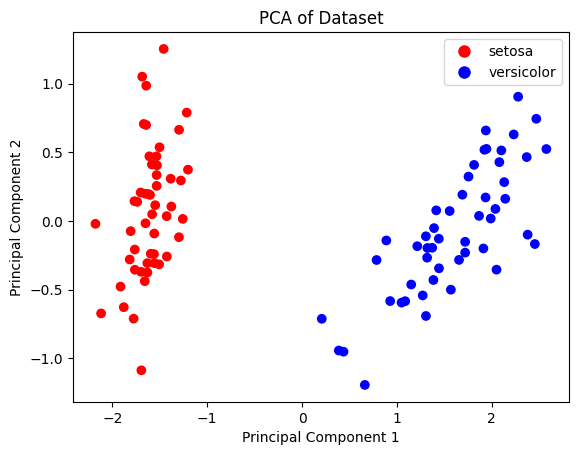

As classes são separáveis linearmente.


In [23]:
# Exemplo de uso com o dataset Iris
from sklearn.datasets import load_iris
iris = load_iris()
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df['species'] = iris.target_names[iris.target]
iris_df.head()

# Chamar a função com o DataFrame, o nome da coluna de classe e os dois rótulos de classe
labels = ['setosa', 'versicolor']
pca_df = apply_and_plot_pca(iris_df, 'species', labels)



class1_points, class2_points, hull_class1, hull_class2 = divide_points(pca_df, 'species')
check_separability(hull_class1, hull_class2)



# Exemplo de uso com o dataset Wine

# from sklearn.datasets import load_breast_cancer

# # Carregar o dataset Wine
# wine = load_diabetes()
# df = pd.DataFrame(wine.data, columns=wine.feature_names)
# df['sex'] = df['sex'].apply(lambda x: 'male' if x > 0 else 'female')
# df.head()

# pca_df = apply_and_plot_pca( df, 'sex', 'male', 'female')
# labels = ['male', 'female']

# hull_class1, hull_class2 = divide_points(pca_df, 'sex')
# check_separability(hull_class1, hull_class2)

# Ponto mais próximo

Calcular o ponto de uma envoltória mais próximo de outra envoltória e em seguida plotar o segmento de reta entre os dois pontos

A menor distância entre as envoltórias convexas é: 1.6195499864076193


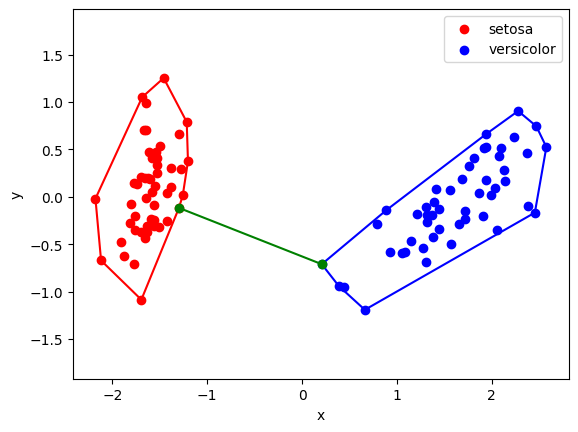

In [24]:
#calcular os dois pontos mais proximos entre as duas envoltórias
# Função para calcular a distância euclidiana entre dois pontos
def euclidean_distance(p1, p2):
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

# Função para calcular a distância do ponto até o segmento de linha
def point_to_segment_distance(p, a, b):
    # Vetorizando os pontos
    p = np.array(p)
    a = np.array(a)
    b = np.array(b)
    
    # Calculando os vetores
    ap = p - a
    ab = b - a
    
    # Calculando o produto escalar
    dot_product = np.dot(ap, ab) / np.dot(ab, ab)
    
    # Evitando que o ponto de projeção saia do segmento de linha
    dot_product = np.clip(dot_product, 0, 1)
    
    # Calculando o ponto de projeção no segmento de linha
    projection = a + dot_product * ab
    
    # Calculando a distância entre o ponto e o ponto de projeção
    return euclidean_distance(p, projection), projection

# Calcular a menor distância entre as envoltórias convexas
min_distance = float('inf')
closest_pair = (None, None)

# Distância entre pontos
for p1 in hull_class1:
    for p2 in hull_class2:
        distance = euclidean_distance(p1, p2)
        if distance < min_distance:
            min_distance = distance
            closest_pair = (p1, p2)

# Distância ponto-segmento
for i in range(len(hull_class1) - 1):
    for p2 in hull_class2:
        distance, projection = point_to_segment_distance(p2, hull_class1[i], hull_class1[i+1])
        if distance < min_distance:
            min_distance = distance
            closest_pair = (projection, p2)

for i in range(len(hull_class2) - 1):
    for p1 in hull_class1:
        distance, projection = point_to_segment_distance(p1, hull_class2[i], hull_class2[i+1])
        if distance < min_distance:
            min_distance = distance
            closest_pair = (p1, projection)

print("A menor distância entre as envoltórias convexas é:", min_distance)

# Plotar os pontos e as envoltórias convexas
plt.scatter(class1_points[:, 0], class1_points[:, 1], c='r', label=labels[0])
plt.scatter(class2_points[:, 0], class2_points[:, 1], c='b', label=labels[1])

hull_class1 = np.vstack((hull_class1, hull_class1[0]))
hull_class2 = np.vstack((hull_class2, hull_class2[0]))

plt.plot(hull_class1[:, 0], hull_class1[:, 1], 'r-')
plt.plot(hull_class2[:, 0], hull_class2[:, 1], 'b-')

# Plotar a menor distância
plt.plot(*closest_pair[0], 'go')  # ponto ou projeção na envoltória 1
plt.plot(*closest_pair[1], 'go')  # ponto ou projeção na envoltória 2
plt.plot([closest_pair[0][0], closest_pair[1][0]], 
         [closest_pair[0][1], closest_pair[1][1]], 'g-')  # linha representando a menor distância

plt.xlabel(pca_df.columns[0])
plt.ylabel(pca_df.columns[1])
plt.legend()
plt.axis('equal')
plt.show()

# Linha perpendicular de separação

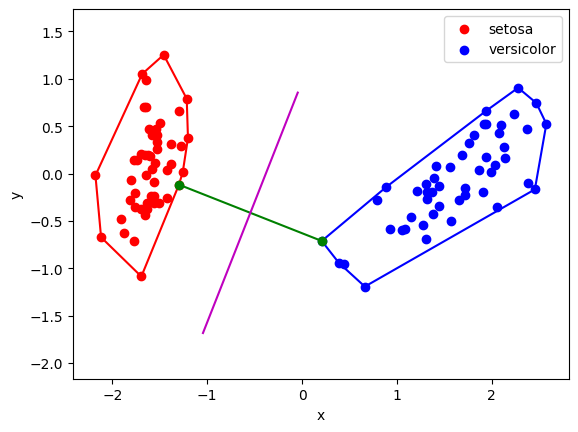

In [25]:
def compute_perpendicular_line(p1, p2):
    # Calculate the slope of the line formed by the two closest points
    if p2[0] - p1[0] != 0:
        slope = (p2[1] - p1[1]) / (p2[0] - p1[0])
        # Calculate the slope of the perpendicular line
        if slope != 0:
            perp_slope = -1 / slope
        else:
            perp_slope = 0  # horizontal line
    else:
        perp_slope = float('inf')  # vertical line

    # Calculate the midpoint of the segment
    midpoint = [(p1[0] + p2[0]) / 2, (p1[1] + p2[1]) / 2]

    # Calculate the y-intercept of the perpendicular line
    y_intercept = midpoint[1] - perp_slope * midpoint[0]

    return perp_slope, y_intercept, midpoint

# Extract the slope, y-intercept, and midpoint of the perpendicular line
perp_slope, y_intercept, midpoint = compute_perpendicular_line(closest_pair[0], closest_pair[1])

# Plot the points and convex hulls
plt.scatter(class1_points[:, 0], class1_points[:, 1], c='r', label=labels[0])
plt.scatter(class2_points[:, 0], class2_points[:, 1], c='b', label=labels[1])

plt.plot(hull_class1[:, 0], hull_class1[:, 1], 'r-')
plt.plot(hull_class2[:, 0], hull_class2[:, 1], 'b-')

# Plot the shortest distance
plt.plot(*closest_pair[0], 'go')
plt.plot(*closest_pair[1], 'go')
plt.plot([closest_pair[0][0], closest_pair[1][0]], 
         [closest_pair[0][1], closest_pair[1][1]], 'g-')

margin = 0.5  # Adjust this value as needed

# Adjust the x-values for plotting the perpendicular line
if abs(perp_slope) != float('inf'):
    x = np.linspace(midpoint[0] - margin, midpoint[0] + margin, 400)
    y = perp_slope * x + y_intercept
    plt.plot(x, y, 'm-')
else:
    plt.axvline(x=midpoint[0], color='m', linestyle='-')

# Set the plot limits to focus on the region of interest
plt.xlim(midpoint[0] - margin, midpoint[0] + margin)
plt.ylim(midpoint[1] - margin, midpoint[1] + margin)

plt.xlabel(pca_df.columns[0])
plt.ylabel(pca_df.columns[1])
plt.legend()
plt.axis('equal')
plt.show()


## Verificar à qual classe um novo ponto pertence

In [26]:
import numpy as np
import matplotlib.pyplot as plt

def perpendicular_line_equation(closest_pair):
    
    #Calcula a equação da reta perpendicular que passa pelo ponto médio

    p1, p2 = closest_pair

    midpoint = [(p1[0] + p2[0]) / 2, (p1[1] + p2[1]) / 2]
    
    if p2[0] - p1[0] != 0:
        slope = (p2[1] - p1[1]) / (p2[0] - p1[0])
        perp_slope = -1 / slope if slope != 0 else float('inf')
    else:
        perp_slope = 0

    A = -perp_slope
    B = 1
    C = perp_slope * midpoint[0] - midpoint[1]

    line_coeficients = [A, B, C]
    return line_coeficients
    

def class_position(classes, closest_pair, line_coeficients):

    A, B, C = line_coeficients

    value = A * closest_pair[0][0] + B * closest_pair[0][1] + C
    if value > 0:
        class_above = labels[0]
        class_below = labels[1]
        return class_above, class_below
    elif value < 0:
        class_above = labels[1]
        class_below = labels[0]
        return class_above, class_below


def determine_class(class_above, class_below, point, line_coeficients):

    A, B, C = line_coeficients

    #Determina a qual classe o ponto pertence

    value = A * point[0] + B * point[1] + C
    
    if value > 0:
        return class_above
    elif value < 0:
        return class_below
    else:
        return "on the line"
   


def plot_data( class1_points, class2_points, hull_class1, hull_class2, closest_pair, test_point, line_coeficients):
    A, B, C = line_coeficients

    #Plota o gráfico
    plt.scatter(class1_points[:, 0], class1_points[:, 1], c='r', label=labels[0])
    plt.scatter(class2_points[:, 0], class2_points[:, 1], c='b', label=labels[1])

    plt.plot(hull_class1[:, 0], hull_class1[:, 1], 'r-')
    plt.plot(hull_class2[:, 0], hull_class2[:, 1], 'b-')

    # Plot the shortest distance
    plt.plot(*closest_pair[0], 'g-')
    plt.plot(*closest_pair[1], 'g-')
    plt.plot([closest_pair[0][0], closest_pair[1][0]], 
            [closest_pair[0][1], closest_pair[1][1]], 'g-')

    margin = 0.5  # Adjust this value as needed

    # Adjust the x-values for plotting the perpendicular line
    if abs(perp_slope) != float('inf'):
        x = np.linspace(midpoint[0] - margin, midpoint[0] + margin, 400)
        y = perp_slope * x + y_intercept
        plt.plot(x, y, 'm-')
    else:
        plt.axvline(x=midpoint[0], color='m', linestyle='-')

    x_limits = plt.gca().get_xlim()
    # Set the plot limits to focus on the region of interest
    plt.xlim(midpoint[0] - margin, midpoint[0] + margin)
    plt.ylim(midpoint[1] - margin, midpoint[1] + margin)
    plt.plot(test_point[0], test_point[1], 'o', color='magenta', label='Test Point')

    plt.xlabel(pca_df.columns[0])
    plt.ylabel(pca_df.columns[1])
    plt.legend()
    plt.axis('equal')
    plt.show()



The test point belongs to the class: versicolor


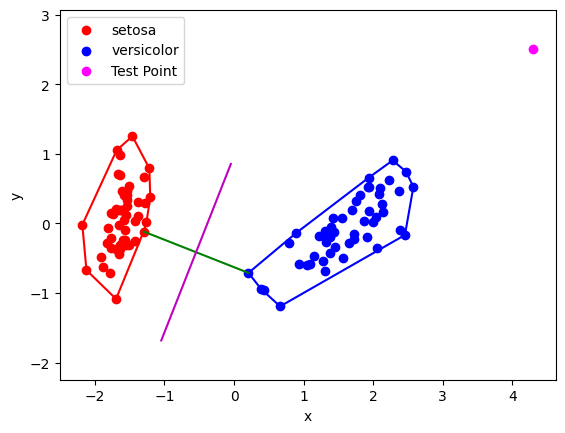

In [27]:
# Exemplo de uso:
line_coeficients = perpendicular_line_equation(closest_pair)
test_point = [4.3, 2.5]
class_above, class_below = class_position(classes, closest_pair, line_coeficients)
species = determine_class(class_above, class_below, test_point, line_coeficients)
print(f"The test point belongs to the class: {species}")
plot_data(class1_points, class2_points, hull_class1, hull_class2, closest_pair, test_point, line_coeficients)



In [28]:
#testset

line_coeficients = perpendicular_line_equation(closest_pair)
class_above, class_below = class_position(classes, closest_pair, line_coeficients)

def predict_classes(df, line_coeficients, class_above, class_below):
    
   #Aplica a função determine_class para cada ponto do dataset e armazena o resultado na coluna 'Predicted Class'
   df['Predicted Class'] = df.apply(lambda row: determine_class([row['x'], row['y']], line_coeficients, class_above, class_below), axis=1)
   return df